# CQA Lasso regression model test10

11/12/2018    

delayed return  
84_Q data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

### import alpha library

In [3]:
# read data
#data_matrix1 = pd.read_csv('/home/system99/Downloads/data_matrix_20_Q.csv')
#data_matrix2 = pd.read_csv('/home/system99/Downloads/data_matrix_21_to_40_Q.csv')
#data_matrix3 = pd.read_csv('/home/system99/Downloads/data_matrix_41_to_60_Q.csv')
#data_matrix4 = pd.read_csv('/home/system99/Downloads/data_matrix_61_to_84_Q.csv')
data_matrix1 = pd.read_csv("C:\\Users\\tony\\Desktop\\CQA\\data\\data_matrix_20_Q.csv")
data_matrix2 = pd.read_csv("C:\\Users\\tony\\Desktop\\CQA\\data\\data_matrix_21_to_40_Q.csv")
data_matrix3 = pd.read_csv("C:\\Users\\tony\\Desktop\\CQA\\data\\data_matrix_41_to_60_Q.csv")
data_matrix4 = pd.read_csv("C:\\Users\\tony\\Desktop\\CQA\\data\\data_matrix_61_to_84_Q.csv")

In [4]:
data_matrix = pd.concat([data_matrix1,data_matrix2,data_matrix3,data_matrix4],ignore_index=True)

### monthly return

In [5]:
monthly_returns = data_matrix[['asOfDate','tic','Return']]

In [6]:
tics = data_matrix['tic']
dates = data_matrix['asOfDate']
dates = dates.apply(lambda x: x[:7])

In [7]:
dates

0         2010-09
1         2010-09
2         2010-09
3         2010-09
4         2010-09
5         2010-09
6         2010-09
7         2010-09
8         2010-09
9         2010-09
10        2010-09
11        2010-09
12        2010-09
13        2010-09
14        2010-09
15        2010-09
16        2010-09
17        2010-09
18        2010-09
19        2010-09
20        2010-09
21        2010-09
22        2010-09
23        2010-09
24        2010-09
25        2010-09
26        2010-09
27        2010-09
28        2010-09
29        2010-09
           ...   
251970    2017-08
251971    2017-08
251972    2017-08
251973    2017-08
251974    2017-08
251975    2017-08
251976    2017-08
251977    2017-08
251978    2017-08
251979    2017-08
251980    2017-08
251981    2017-08
251982    2017-08
251983    2017-08
251984    2017-08
251985    2017-08
251986    2017-08
251987    2017-08
251988    2017-08
251989    2017-08
251990    2017-08
251991    2017-08
251992    2017-08
251993    2017-08
251994    

## 1. Data preprocess

separate dates, returns (label) and alphas (data) from data matrix

In [8]:
mask = [i for i in list(range(14,488))+list(range(498,499))]
alpha_library = data_matrix.iloc[:,mask]
alpha_library.head()

,ALPHA_77,ALPHA_267,ALPHA_505,ALPHA_572,ALPHA_25,SPPIVY,ALPHA_129,ALPHA_264,OPMBD,OPMBD1,...,DOQ,DOY,IBADJQ,IBQ,IBADJY,IBY,CSH12Q,CSHPRQ,CSHPRY,LIQUIDITY.1
0,-0.129319,0.053984,0.306399,0.346287,-0.066755,14.0,0.000000,2.028620,0.287070,0.287070,...,0.0,0.0,3253.0,3253.0,9705.0,9705.0,905.3295,912.197,907.762,5363.250030
1,-0.273262,-0.003845,0.233960,-0.231986,-0.166918,-771.0,1.056310,-1.211370,0.295827,0.295827,...,0.0,0.0,2741.0,3123.0,5331.0,6305.0,9102.1828,9956.773,9570.166,1891.193156
2,-0.323743,0.103459,0.204940,0.259946,1.604720,-1061.0,1.980420,-0.135714,0.300105,0.300105,...,-3.0,208.0,2674.0,2700.0,6860.0,6917.0,23195.6250,28849.400,28646.900,1551.418943
3,-0.055053,0.058377,0.426733,2.559450,-0.082981,NaN,0.536183,0.816442,0.414490,0.414490,...,0.0,0.0,4518.0,4518.0,18760.0,18760.0,8813.0000,8712.000,8813.000,1474.759158
4,-0.127456,0.058582,0.412080,1.127290,-0.024606,0.0,0.000000,1.159110,0.396041,0.396041,...,0.0,0.0,1840.0,1840.0,3795.0,3795.0,317.4950,318.350,318.123,1353.579613


### Function1: delete columns with too many nan 
input:    
data -- dataframe;   
ratio -- threshold of (number of NA's)/(data size);
      
output:    
data -- dataframe which the ratio less than threshold ratio

In [9]:
# delete columns with too many nan
def delete_columns_with_too_many_nan(data, ratio):
    return data.loc[:,data.isnull().mean()<(ratio)]

After delete all the alpha with >0.1 NA's, the alpha library contains 464 alphas.

In [10]:
alpha_library = delete_columns_with_too_many_nan(alpha_library, 0.1)
alpha_library.shape

(252000, 475)

### Function2: replace NA's with mean in the column

In [11]:
# replace nan with mean
def replace_nan_with_mean(data):
    col_names = list(data)
    col_mean = np.nanmean(data, axis=0)
    values = {}
    for i in range(len(col_names)):
        values[col_names[i]] = col_mean[i]
    return data.fillna(values)


In [12]:
alpha_library = replace_nan_with_mean(alpha_library)

### Function3: data mask
input:   
start_year,start_quarter,train_time,delay

output:   
training data

In [13]:
def monthly_delay(start_year,start_month,delay):
    if start_month<10:
        start_time = str(start_year)+'-0'+str(start_month)
    else:
        start_time = str(start_year)+'-'+str(start_month)    
    
    response_month = start_month+delay
    if response_month>12:
        response_year = start_year+1
        response_month = response_month-12
    else:
        response_year = start_year
        
    if response_month<10:
        response_time = str(response_year)+'-0'+str(response_month)
    else:
        response_time = str(response_year)+'-'+str(response_month)
        
    return start_time,response_time


#convert from the original start year and month to one month later on for testing sample
def convert_to_test(start_year,start_month,delay):
    #normal addition process
    #if start_month <12:
    if start_month <9:
        start_yr = start_year
        #start_m = start_month +1
        start_m = start_month +delay
        
    #adding another year
    else: 
        start_yr = start_year + 1 
        #start_m = 1 
        start_m = start_month + delay - 12
    
    return start_yr, start_m 

In [14]:
def retrive_train(alpha_library,monthly_returns,dates,tics,start_year,start_month,delay):
    start_time,response_time = monthly_delay(start_year,start_month,delay)
    
    train_mask = dates == start_time
    train_alpha  = alpha_library[train_mask]
    train_tic = list(tics[train_mask])
    
    response_mask = dates == response_time
    response_return = monthly_returns['Return'][response_mask]
    response_tic = monthly_returns['tic'][response_mask]

    # create a tic-return dictionary
    response_dict = dict([(i,j) for i,j in zip(response_tic,response_return)])

    # create returns
    train_Y = np.zeros([train_alpha.shape[0],1])
    for i in range(len(train_tic)):
        if train_tic[i] in response_dict:
            train_Y[i] = response_dict[train_tic[i]]
        else:
            train_Y[i] = None
            
    train_Y = pd.DataFrame(train_Y)
    
    # filter nan in returns
    train_alpha['label'] = train_Y.values
    train_Y = train_alpha.loc[~train_alpha['label'].isnull(),'label']
    train_X = train_alpha.loc[~train_alpha['label'].isnull(),].drop(columns=['label','LIQUIDITY.1'])
    liquidity_vec = train_alpha.loc[~train_alpha['label'].isnull(),'LIQUIDITY.1']

    return train_X,train_Y,liquidity_vec

In [15]:
def retrive_test(alpha_library,monthly_returns,dates,tics,start_year,start_month,delay):
    start_time,response_time = monthly_delay(start_year,start_month,delay)
    test_mask = dates == start_time
    test_X_1  = alpha_library[test_mask]
    test_X = test_X_1.drop(columns=['LIQUIDITY.1'])
    test_tic = list(tics[test_mask])
    liquidity_test = test_X_1.loc[:,'LIQUIDITY.1']

    return test_X,test_tic,response_time,liquidity_test

## 2. Lasso regression

In [16]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
import warnings
warnings.filterwarnings('ignore')

In [17]:
import os
#returns_folder = '/home/system99/dr/' 
returns_folder = "C:\\Users\\tony\\Desktop\\CQA\\data\\dr\\"
files_list = os.listdir(returns_folder)
files_list = sorted(files_list)

There are two different strategy for the portfolio management.   
(1) invest one (or negetive one) dollar every day for each company  
(2) invest one(or negetive one) dollar in the beginning of every month for each company  

The following function is based on assumption (2).

In [18]:
def portfolio_monthly_returns(date,files_list,returns_folder,returns,x):
    daily_returns = pd.DataFrame([], columns=('date','portfolio_value','portfolio_return'))
    i = 0
    for temp_file in files_list:
        if date in temp_file:
            return_temp = pd.read_csv(returns_folder+temp_file)
            return_temp = return_temp.dropna()
        
            for j in range(return_temp.shape[0]):
                if return_temp.iloc[j,0] in returns:
                    comp_tic = return_temp.iloc[j,0]
                    returns[comp_tic] = returns[comp_tic]*(1+return_temp.iloc[j,1])
            ###
            daily_returns.loc[i] = [pd.Timestamp(temp_file[:10]),x+sum(returns.values()),None]
            ###
            #daily_returns.loc[i] = [pd.Timestamp(temp_file[:10]),1+sum(returns.values()),None]
            if i>0:
                daily_returns['portfolio_return'][i] = (daily_returns['portfolio_value'][i]-daily_returns['portfolio_value'][i-1])/daily_returns['portfolio_value'][i-1]
                #daily_returns['portfolio_return'][i] = 
                
            else:
                daily_returns['portfolio_return'][i] = (daily_returns['portfolio_value'][i]-x)/x
            i = i+1
    month_return = (daily_returns['portfolio_value'][i-1]-x)/x

    return daily_returns,month_return 

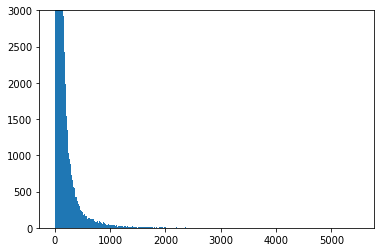

In [19]:
liquidity_v = data_matrix['LIQUIDITY.1']
#print(liquidity_v)


from scipy.stats import trim_mean, kurtosis
from scipy.stats.mstats import mode, gmean, hmean
liquidity_v.describe()
hist = np.histogram(liquidity_v)
hist

import matplotlib.pyplot as plt

plt.hist(x=liquidity_v,range=[0, 5500],bins = 300)
axes = plt.gca()
axes.set_ylim([0,3000])
#plt.grid(axis='y', alpha=0.75)
#plt.xlabel('Value')
#plt.ylabel('Frequency')
#plt.title('My Very Own Histogram')
#plt.text(23, 45, r'$\mu=15, b=3$')

def scaling_classify(scaling_factor, liquidity_vector, threshold_vector):
    #choose scaling based on quantiles and assign threshold_vector values
    s1 = np.quantile(liquidity_vector, 0.25)
    s2 = np.quantile(liquidity_vector, 0.5)
    s3 = np.quantile(liquidity_vector, 0.75)
    for i in range(len(scaling_factor)):
        #case 1 (below 25th percentile)
        if liquidity_vector[i] <s1:
            scaling_factor[i] = threshold_vector[0]
        #case 2 (between 25th percentile and 50th percentile)
        elif liquidity_vector[i] >=s1 and liquidity_vector[i] <s2:
            scaling_factor[i] = threshold_vector[1]
        #case 3 (between 50th percentile and 75th percentile)
        elif liquidity_vector[i] >=s2 and liquidity_vector[i]< s3:
            scaling_factor[i] = threshold_vector[2]
        #case 4 (above 75th percentile)
        elif liquidity_vector[i] >=s3:
            scaling_factor[i] = threshold_vector[3]
        else:
            return()
    return(scaling_factor)


def weight_adjust(scaling_factor_new_b,scaling_factor_new_s,Y_b,Y_s,y_b,y_s,m_b,m_s):
    #rank portfolio_weight buying rank (in the total return array), but only ranking within 25th quantile liquid stock subset
    #print(y_b)
    tic_b = sorted(range(len(Y_b)), key=lambda k: (Y_b[k]*scaling_factor_new_b[k]))
    best_tic = tic_b[-m_b:]
    
    print(best_tic)
    
    #rank portfolio_weight sellinging rank (in the total return array), but only ranking within 25th quantile liquid stock subset
    tic_s = sorted(range(len(Y_s)), key=lambda k: (Y_s[k]*scaling_factor_new_s[k]))
    worst_tic = tic_s[:m_s]
    
    print(worst_tic)
    
    #make all scaling weights other than the top m_b ranking buying stock tend to zero:
    j_1 = 0
    for aa in range(len(scaling_factor_new_b)):
        if aa in best_tic:
            scaling_factor_new_b[aa] = scaling_factor_new_b[aa] 
            j_1 = j_1 +1
        else:
            scaling_factor_new_b[aa] = scaling_factor_new_b[aa]*0
            
    #make all scaling weights other than the bottom m_s ranking selling stock tend to zero:
    j_2 = 0
    for bb in range(len(scaling_factor_new_s)):
        if bb in worst_tic:
            scaling_factor_new_s[bb] = scaling_factor_new_s[bb]
            j_2 = j_2+1 
        else:
            scaling_factor_new_s[bb] = scaling_factor_new_s[bb]*0
      
            
    return scaling_factor_new_b,scaling_factor_new_s,j_1,j_2
        
    

def weight_balance(portfolio_pre_weights,scaling_factor,x):
    total_sum = abs(np.dot(portfolio_pre_weights,scaling_factor))
    if total_sum == x/2:
        return(portfolio_pre_weights,scaling_factor)
    elif total_sum < x/2:
        rescaling = (x/2)/total_sum
        portfolio_pre_weights = [rescaling*i for i in portfolio_pre_weights]
        return(portfolio_pre_weights,scaling_factor)
    elif total_sum > x/2:
        rescaling = (x/2)/total_sum
        portfolio_pre_weights = [rescaling*i for i in portfolio_pre_weights]
        return(portfolio_pre_weights,scaling_factor)
    else:
        return()
        
     

In [38]:
from sklearn.ensemble import RandomForestRegressor
#from sklearn.ensemble import RandomForestClassifier
from matplotlib.backends.backend_pdf import PdfPages
#pp = PdfPages('foo.pdf')

######################
#number of stocks to buy
m_b = 100 #50  #30
#number of stocks to sell
m_s = 5   #10 #50 #30
#######################


delay = 4 # delay
m = 1500 # number_of_stocks
portfolio_returns = pd.DataFrame([], columns=('date','portfolio_return'))
portfolio_daily_returns = pd.DataFrame([], columns=('date','portfolio_value','portfolio_return'))
i = 0
set_dates = list(sorted(set(dates)))
x = 1
##for k in range(len(set_dates)-delay):
#for k in range(len(set_dates)-delay-1):
for k in range(len(set_dates)-delay-delay):
    date = set_dates[i]
    start_year = int(date[:4])
    start_month = int(date[5:7])
    
    train_X,train_Y,liquidity_train = retrive_train(alpha_library,monthly_returns,dates,tics,start_year,start_month,delay)
    
    ##############################################
    #roll over the relationship one period ahead
    #start_y, start_m = convert_to_test(start_year,start_month)
    start_y, start_m = convert_to_test(start_year,start_month,delay)
    test_X,test_tic,response_time,liquidity_test = retrive_test(alpha_library,monthly_returns,dates,tics,start_y,start_m,delay)
    ################################################
    
    
    #test_X,test_tic,response_time,liquidity_test =retrive_test(alpha_library,monthly_returns,dates,tics,start_year,start_month,delay)
        
    #####################################################################33
    # Create linear regression object
    #regr_Lasso = linear_model.Lasso(alpha=.1)

    # Train the model using the training sets
    #regr_Lasso.fit(train_X, train_Y)

    # Make predictions using the testing set
    #pred_Y_Lasso = regr_Lasso.predict(test_X)
    #############################################################################
    
    #convert to binary return of Buy/sell
    #train_Y = np.where(train_Y > np.repeat(0, len(train_Y)), "Buy","Sell")

    #create random forest object
    rf = RandomForestRegressor()
    #rf = RandomForestClassifier()
    # Train the model on training data
    rf.fit(train_X, train_Y);
    #make predictions using testing set 
    pred_Y_rf = rf.predict(test_X)
    
    #print(pred_Y_rf)
    
    ############################################################################
    
    # rank company by predicted returns
    #companies = test_tic
    #pred = dict(zip(companies, pred_Y_Lasso))
    #pred = dict(zip(companies, pred_Y_rf))
    #comp_ranked = sorted(pred, key=pred.__getitem__, reverse=True)
    
    # dictionary for returns
    #best_tic = comp_ranked[:m]
    #worst_tic = comp_ranked[-m:]
    #returns = {}
    #for j in best_tic:
    #    returns[j] = x/m/2
    #for j in worst_tic:
    #    returns[j] = -x/m/2
    
    ################################################################################
    #long the stocks that classify as Buy, and short the stocks that classify as sell
    companies = test_tic
    pred = dict(zip(companies, pred_Y_rf))

    #################################################################################
    #equal weighted dollar neutral portfolio#
    #number of longing stocks to account for dollar-neutral
    ls = np.where(pred_Y_rf >= 0,1,0)
    nl = sum(ls)
    #print(nl)
    
     #number of shorting stocks to account for dollar-neutral
    ss = np.where(pred_Y_rf < 0,1,0)
    ns = sum(ss)
    #print(ns)
    
    #returns = {}
    #for j in companies:
    #    if pred[j] == 'Buy':
    #        returns[j] = x/nl/2
    #    else: 
    #        returns[j] = -x/ns/2
    ###################################################################################
    
    #create vector(for both long and short positions) for liquidity factor
    #and then try to see distribution of the liquidity factor for each portfolio
    lf_b = {}
    lf_s = {}
    y_b = {}
    y_s = {}
    lf_all = {}
    combined_vector = list(zip(pred_Y_rf,liquidity_test))
    lid = dict(zip(companies,combined_vector ))
    for j in companies:
        if lid[j][0] >= 0 :
            #lf_b[j] = lid[j][1] 
            #y_b[j] = lid[j][0]
            y_b[j] = [lid[j][0],lid[j][1]]
        else: 
            #lf_s[j] = lid[j][1]
            #y_s[j] = lid[j][0]
            y_s[j] = [lid[j][0],lid[j][1]]
        lf_all[j]= lid[j][1]
     
    #plot different histograms for both long and short side portfolio's liquidity
    #####################################################
    #data_b = pd.DataFrame.from_dict(lf_b,orient = 'index')
    #data_s = pd.DataFrame.from_dict(lf_s,orient = 'index')
    #L_b = list(lf_b.values())
    #L_s = list(lf_s.values())

    
    #Y_b = list(y_b.values())
    #Y_s = list(y_s.values())
    #Y_b = list(y_b[lf_b.keys()])
    #Y_s = list(y_s[lf_s.keys()])
    data_b = pd.DataFrame.from_dict(y_b,orient = 'index')
    data_s = pd.DataFrame.from_dict(y_s,orient = 'index')
    Y_b = list(data_b.iloc[:,0])
    Y_s = list(data_s.iloc[:,0])
    
    ##################################################
    
    
    #plt.hist(x= L_b,bins = 300)
    #plt.title('buy')
    #plt.show()
    #plt.savefig(str(i)+"Buy")
    #plt.hist(x= L_s,bins = 300)
    #plt.title('sell')

    ###########################
    #liquidity_weighted portfolio optimization#
    
    weight_b = data_b.iloc[:,1].values
    weight_s = data_s.iloc[:,1].values
    
    ##################################################################################
    #initialize the portfolio weights
    ####################################################################################
    # and account for only top m_b number of buying stocks
    portfolio_weights_b = np.tile(x/m_b/1000,nl)
    ####################################################################################
    # similarly, account for only bottom m_s number of selling stocks
    portfolio_weights_s = np.tile(-x/m_s/1000,ns)
    ####################################################################################
    scaling_factor_b = np.tile(0,nl) 
    scaling_factor_s = np.tile(0,ns)
    
    #change scaling of the scaling factor to adjust for liquidity
    ############################
    # 1,2,3,4
    scaling_factor_new_b = scaling_classify(scaling_factor_b,weight_b,[0,0,0,500])
    scaling_factor_new_s = scaling_classify(scaling_factor_s,weight_s,[0,0,0,500])
    print(sum(scaling_factor_new_b))
    print(sum(scaling_factor_new_s))
    
    #### change the scaling further to adjust for top m_b number of buying stocks, and 
    # top m_s number of selling stocks. All other top 25% quantile liquid stocks tend to zero
    scaling_factor_new_b,scaling_factor_new_s,j_1,j_2 = weight_adjust(scaling_factor_new_b,scaling_factor_new_s,Y_b,Y_s,y_b,y_s,m_b,m_s)
    print("j_1",j_1, "j_2",j_2)     
    print(sum(scaling_factor_new_b))
    print(sum(scaling_factor_new_s))
    #print(scaling_factor_new_b)
    
    #rebalance the portfolio weights to make it dollar neutral
    portfolio_weights_b,scaling_factor_new_b= weight_balance(portfolio_weights_b,scaling_factor_new_b,x)
    portfolio_weights_s,scaling_factor_new_s= weight_balance(portfolio_weights_s,scaling_factor_new_s,x)
    
    portfolio_weights_b = np.multiply(portfolio_weights_b,scaling_factor_new_b)
    portfolio_weights_s = np.multiply(portfolio_weights_s,scaling_factor_new_s)
    
    #find the corresponding companies from index, IN THE SAME ORDER
    #then forms a new dictionary of returns
    return_companies = list(data_b.index) + list(data_s.index)
    return_weights = portfolio_weights_b.tolist() + portfolio_weights_s.tolist()
    returns = {}
    for zz in range(len(return_companies)):
        returns[return_companies[zz]]= return_weights[zz]
        
        
    
    
        
    daily_returns,portfolio_return = portfolio_monthly_returns(response_time,files_list,returns_folder,returns,x)
    print('portfolio_return for',response_time, 'is ',portfolio_return)
    
    #sharp = np.mean(daily_returns['portfolio_return'])/np.std(daily_returns['portfolio_return'])
    #print('sharp ratio for',response_time, 'is ', sharp)
    
    portfolio_daily_returns = pd.concat([portfolio_daily_returns, daily_returns], ignore_index=True)
    portfolio_returns.loc[i] = [pd.Timestamp(response_time),portfolio_return]
    i = i+1
    x = daily_returns.iloc[-1,1]
    print(x)
    
    
    
#pp.close()
    

201500
173500
[17, 292, 338, 330, 100, 199, 231, 263, 384, 308, 227, 123, 121, 257, 293, 176, 155, 324, 304, 296, 31, 32, 284, 71, 243, 291, 252, 368, 83, 388, 224, 168, 14, 288, 79, 398, 286, 295, 189, 228, 236, 365, 267, 211, 80, 174, 283, 201, 54, 371, 92, 98, 280, 392, 62, 173, 111, 223, 356, 375, 61, 52, 269, 22, 325, 27, 94, 57, 278, 349, 72, 193, 23, 95, 141, 209, 266, 198, 374, 204, 299, 350, 268, 107, 251, 131, 110, 222, 391, 50, 28, 170, 382, 364, 118, 241, 225, 321, 281, 48]
[93, 62, 290, 291, 155]
j_1 100 j_2 5
50000
2500
portfolio_return for 2011-05 is  -0.009824065353451594
0.9901759346465484
325500
50000
[385, 373, 339, 624, 293, 334, 604, 636, 202, 555, 565, 561, 597, 460, 647, 52, 502, 354, 587, 452, 606, 28, 53, 249, 596, 553, 508, 536, 234, 95, 48, 297, 248, 174, 474, 463, 60, 255, 541, 607, 253, 284, 94, 600, 585, 468, 557, 493, 520, 427, 137, 119, 464, 433, 402, 429, 526, 139, 56, 640, 390, 327, 622, 347, 271, 87, 63, 183, 639, 592, 643, 393, 445, 270, 499, 465, 56

portfolio_return for 2012-07 is  -0.004087212922033594
1.2296743962709968
6500
369000
[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 1, 6, 11, 0, 12, 10, 7, 3, 9, 2, 8, 4, 5]
[700, 263, 137, 530, 645]
j_1 51 j_2 5
6500
2500
portfolio_return for 2012-08 is  -0.025641816964388987
1.1981433104760204
368500
6500
[388, 619, 483, 450, 36, 434, 532, 137, 294, 29, 536, 50, 512, 333, 457, 320, 55, 441, 674, 327, 631, 433, 334, 498, 707, 672, 524, 664, 477, 408, 353, 332, 240, 459, 613, 731, 516, 569, 730, 690, 645, 412, 289, 187, 583, 732, 233, 143, 437, 112, 368, 245, 605, 255, 542, 521, 430, 485, 258, 226, 122, 40, 268, 673, 57, 677, 501, 539, 687, 173, 316, 378, 683, 610, 429, 606, 692, 479, 523, 480, 593, 151, 561, 602, 354, 509, 392, 565, 276, 377, 660, 585, 350, 541, 702, 443, 635, 598, 722, 186]
[4, 5, 0, 1, 2]
j_1 100 j_2 5
50000
2500
portfolio_return for 2012-09 is  0.0061497508172

portfolio_return for 2013-09 is  0.041941335753282266
1.3582101292900273
357000
18000
[33, 40, 616, 606, 278, 129, 133, 249, 489, 35, 458, 333, 53, 39, 288, 689, 108, 546, 622, 494, 347, 671, 45, 588, 219, 611, 212, 113, 62, 632, 402, 597, 552, 562, 120, 647, 202, 576, 556, 216, 144, 168, 266, 530, 355, 306, 303, 506, 218, 236, 115, 398, 468, 455, 592, 36, 329, 380, 579, 122, 483, 384, 265, 694, 71, 126, 284, 678, 200, 476, 195, 123, 61, 702, 65, 609, 381, 378, 539, 449, 421, 708, 12, 696, 461, 23, 551, 372, 351, 263, 427, 27, 420, 603, 614, 645, 255, 573, 319, 549]
[7, 8, 6, 1, 12]
j_1 100 j_2 5
50000
2500
portfolio_return for 2013-10 is  -0.005563878297564378
1.3506532134281384
67500
308000
[33, 91, 60, 23, 73, 5, 46, 81, 44, 70, 103, 20, 122, 39, 100, 121, 54, 12, 80, 48, 82, 106, 50, 111, 95, 84, 104, 118, 134, 28, 128, 101, 6, 127, 123, 11, 41, 62, 98, 8, 96, 13, 36, 32, 117, 75, 129, 35, 61, 132, 29, 99, 21, 2, 119, 116, 133, 49, 3, 89, 59, 130, 17, 55, 38, 85, 74, 113, 78, 64, 7

portfolio_return for 2014-11 is  0.004744814362854882
1.1926599571555743
13500
362000
[34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 10, 8, 19, 11, 6, 23, 15, 0, 12, 17, 20, 21, 18, 22, 4, 24, 13, 26, 5, 3, 16, 2, 1, 7, 25, 14, 9]
[587, 404, 510, 285, 583]
j_1 100 j_2 5
13500
2500
portfolio_return for 2014-12 is  0.052917831989897815
1.2557729363894117
316000
59500
[482, 443, 202, 440, 298, 168, 101, 137, 396, 565, 556, 265, 123, 204, 201, 403, 539, 337, 523, 436, 575, 191, 213, 445, 549, 40, 564, 371, 568, 455, 309, 377, 501, 329, 379, 505, 136, 630, 267, 172, 622, 527, 175, 289, 368, 119, 360, 188, 82, 60, 153, 338, 594, 414, 382, 509, 618, 408, 197, 577, 290, 470, 308, 452, 460, 299, 167, 489, 425, 430, 295, 302, 126, 557, 150, 410, 2

portfolio_return for 2016-01 is  0.03820950386722894
1.2280848994675917
183000
192000
[267, 316, 197, 364, 5, 47, 270, 287, 344, 38, 87, 125, 83, 97, 341, 293, 65, 141, 80, 174, 211, 142, 242, 11, 196, 247, 278, 315, 252, 325, 203, 48, 250, 283, 309, 348, 191, 173, 36, 182, 289, 262, 354, 3, 295, 193, 214, 110, 213, 314, 177, 192, 184, 218, 105, 233, 226, 249, 151, 237, 16, 30, 296, 57, 126, 166, 21, 89, 190, 147, 85, 248, 111, 258, 317, 215, 205, 279, 77, 137, 81, 1, 154, 37, 264, 312, 266, 254, 338, 310, 194, 202, 281, 60, 31, 51, 107, 236, 2, 181]
[343, 81, 330, 288, 328]
j_1 100 j_2 5
50000
2500
portfolio_return for 2016-02 is  0.04231666026777581
1.2800533509383474
21500
354000
[113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 0, 30, 23, 24, 31, 17,

portfolio_return for 2017-03 is  0.02006260287599033
0.9817659992379674
223500
151500
[130, 435, 129, 192, 84, 82, 111, 397, 68, 358, 241, 175, 272, 265, 40, 109, 9, 372, 302, 215, 409, 200, 98, 197, 122, 347, 87, 376, 433, 173, 318, 445, 208, 47, 324, 268, 58, 306, 4, 76, 88, 279, 159, 370, 294, 417, 50, 204, 304, 346, 230, 119, 167, 30, 131, 413, 22, 65, 16, 289, 282, 390, 92, 113, 418, 344, 156, 227, 12, 412, 185, 102, 56, 3, 205, 419, 194, 258, 348, 55, 446, 142, 209, 267, 333, 366, 316, 444, 103, 199, 393, 234, 281, 291, 125, 46, 341, 410, 403, 354]
[76, 277, 107, 279, 197]
j_1 100 j_2 5
50000
2500
portfolio_return for 2017-04 is  -0.010460523926291676
0.971496212512919
301000
74500
[301, 484, 530, 120, 8, 442, 145, 48, 539, 326, 393, 510, 353, 100, 38, 39, 81, 188, 193, 485, 194, 376, 200, 129, 309, 171, 184, 70, 61, 34, 305, 408, 98, 225, 548, 533, 59, 49, 126, 483, 185, 162, 6, 401, 228, 590, 0, 525, 406, 577, 154, 598, 437, 105, 138, 222, 595, 400, 170, 286, 76, 369, 109, 455,

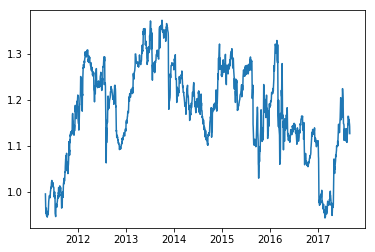

In [39]:
aggregate = [1]
for i in portfolio_daily_returns['portfolio_return']:
    aggregate.append(aggregate[-1]*(i+1))
aggregate = aggregate[1:]
#print(aggregate)
plt.plot(portfolio_daily_returns['date'],aggregate)

In [40]:
portfolio_daily_returns = portfolio_daily_returns.set_index(portfolio_daily_returns['date'])

## 3. output

In [41]:
def mean_return(returns):
    return 252*np.mean(returns)*100
    
def vol(returns):
    return np.sqrt(252)*np.std(returns)*100

def sharpe_ratio(returns):
    return np.sqrt(252)*np.mean(returns)/np.std(returns)

def Sortino(returns):
    return np.sqrt(252)*np.mean(returns)/np.std(returns[returns<0])

def draw_down(returns):
    # We are going to use a trailing 252 trading day window
    window = 252
    # Calculate the max drawdown in the past window days for each day in the series.
    # Use min_periods=1 if you want to let the first 252 days data have an expanding window
    #Roll_Max = pd.rolling_max(returns, window, min_periods=1)
    
    Roll_Max = returns.rolling(window,min_periods = 1).max()
    Daily_Drawdown = returns/Roll_Max - 1.0

    # Then we calculate the minimum daily drawdown, which is equivalent to maximum drawdown 
    # Again, use min_periods=1 if you want to allow the expanding window
    #Max_Daily_Drawdown = pd.rolling_min(Daily_Drawdown, window, min_periods=1)
    Max_Daily_Drawdown = Daily_Drawdown.rolling(window,min_periods = 1).min()
    return Max_Daily_Drawdown

In [42]:
for year in range(2011,2017):
    returns = portfolio_daily_returns[str(year)+'-01-01':str(year+1)+'-01-01']['portfolio_return']
    #print(len(returns))
    print(draw_down(returns)[-1])
    print('year %4d, mean return = %.4f, Volatility = %.4f, sharpe ratio = %.4f, Max_Drawdown Rate = %.4f, Sortino ratio = %.4f' % \
          (year,mean_return(returns),vol(returns),sharpe_ratio(returns),draw_down(returns)[-1],Sortino(returns)))

year 2011, mean return = 26.5144, Volatility = 14.9179, sharpe ratio = 1.7774, Sortino ratio = 2.5355
year 2012, mean return = -2.6766, Volatility = 19.0803, sharpe ratio = -0.1403, Sortino ratio = -0.1549
year 2013, mean return = 13.0534, Volatility = 16.1004, sharpe ratio = 0.8108, Sortino ratio = 0.8171
year 2014, mean return = -0.6582, Volatility = 15.0592, sharpe ratio = -0.0437, Sortino ratio = -0.0654
year 2015, mean return = -3.6634, Volatility = 21.5652, sharpe ratio = -0.1699, Sortino ratio = -0.2383
year 2016, mean return = -4.5368, Volatility = 22.9506, sharpe ratio = -0.1977, Sortino ratio = -0.2333


total portfolio return

In [43]:
aggregate[-1]-1

0.1262548173222433